# Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification


This notebook shows an example for a **arbitrary batch image gradient inversion** as described in "Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification". The setting is a pretrained ResNet-18 and the federated learning algorithm is **fedSGD** in a **cross-silo** setting.

Paper URL: https://arxiv.org/abs/2202.00580

This variant fishes for user data of a single target user by refining an estimate of the user's data distribution over a series of queries. The attacker constructs a binary tree over successive queries until a single data point from the user side is successfully isolated. On average, this should take $\log(n)$ queries for users with $n$ data points from the class that is currently attacked.

#### Abstract
Federated learning (FL) has rapidly risen in popularity due to its promise of privacy and efficiency. Previous works have exposed privacy vulnerabilities in the FL pipeline by recovering user data from gradient updates. However, existing attacks fail to address realistic settings because they either 1) require a `toy' settings with very small batch sizes, or 2) require unrealistic and conspicuous architecture modifications. We introduce a new strategy that dramatically elevates existing attacks to operate on batches of arbitrarily large size, and without architectural modifications. Our model-agnostic strategy only requires modifications to the model parameters sent to the user, which is a realistic threat model in many scenarios. We demonstrate the strategy in challenging large-scale settings, obtaining high-fidelity data extraction in both cross-device and cross-silo federated learning.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case/server=malicious-fishing", "attack=clsattack", "case/user=multiuser_aggregate"])
          
device = torch.device(f'cuda:1') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda', index=1), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.user.user_range = [0, 1]

cfg.case.data.partition = "random" # This is the average case
cfg.case.user.num_data_points = 256
cfg.case.data.default_clients = 32

cfg.case.user.provide_labels = True # Mostly out of convenience
cfg.case.server.target_cls_idx = 0 # Which class to attack?

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of       0:1 for target shape [256, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 256

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
    Number of aggregated users: 1
Server (of type MaliciousClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: unchanged
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variatio

### Simulate an attacked FL protocol

This attack runs a modified server protocol, which is able to query the user multiple times. We record the number of queries and later return it from the user.

In [5]:
[shared_data], [server_payload], true_user_data = server.run_protocol(user)

Computing user update on user 0 in model mode: eval.
Found labels [  8  11  12  13  14  16  17  18  18  21  23  23  25  26  26  26  30  30
  31  31  32  33  33  41  42  49  51  56  57  58  58  61  61  61  66  68
  69  71  72  74  76  76  79  79  81  81  81  84  85  86  87  89  91  92
  95  96  97 100 101 102 104 105 106 108 109 112 115 117 117 120 121 124
 125 126 127 131 133 135 136 136 139 140 140 143 143 144 145 148 149 149
 149 154 155 157 163 164 167 167 167 169 171 171 172 174 175 175 184 188
 188 189 192 192 193 197 197 197 202 204 205 206 212 212 212 213 215 217
 220 220 221 223 225 225 226 227 227 228 228 228 229 229 231 232 235 236
 242 243 243 247 251 251 251 253 255 255 256 257 260 260 261 263 265 267
 268 268 268 269 270 272 275 275 276 276 279 280 284 287 288 295 299 300
 300 301 302 306 310 310 311 315 316 316 317 319 319 319 320 321 322 322
 324 325 326 329 330 331 332 333 337 337 337 338 339 341 343 344 345 345
 347 347 349 350 350 351 352 352 353 357 360 361 362 362 3

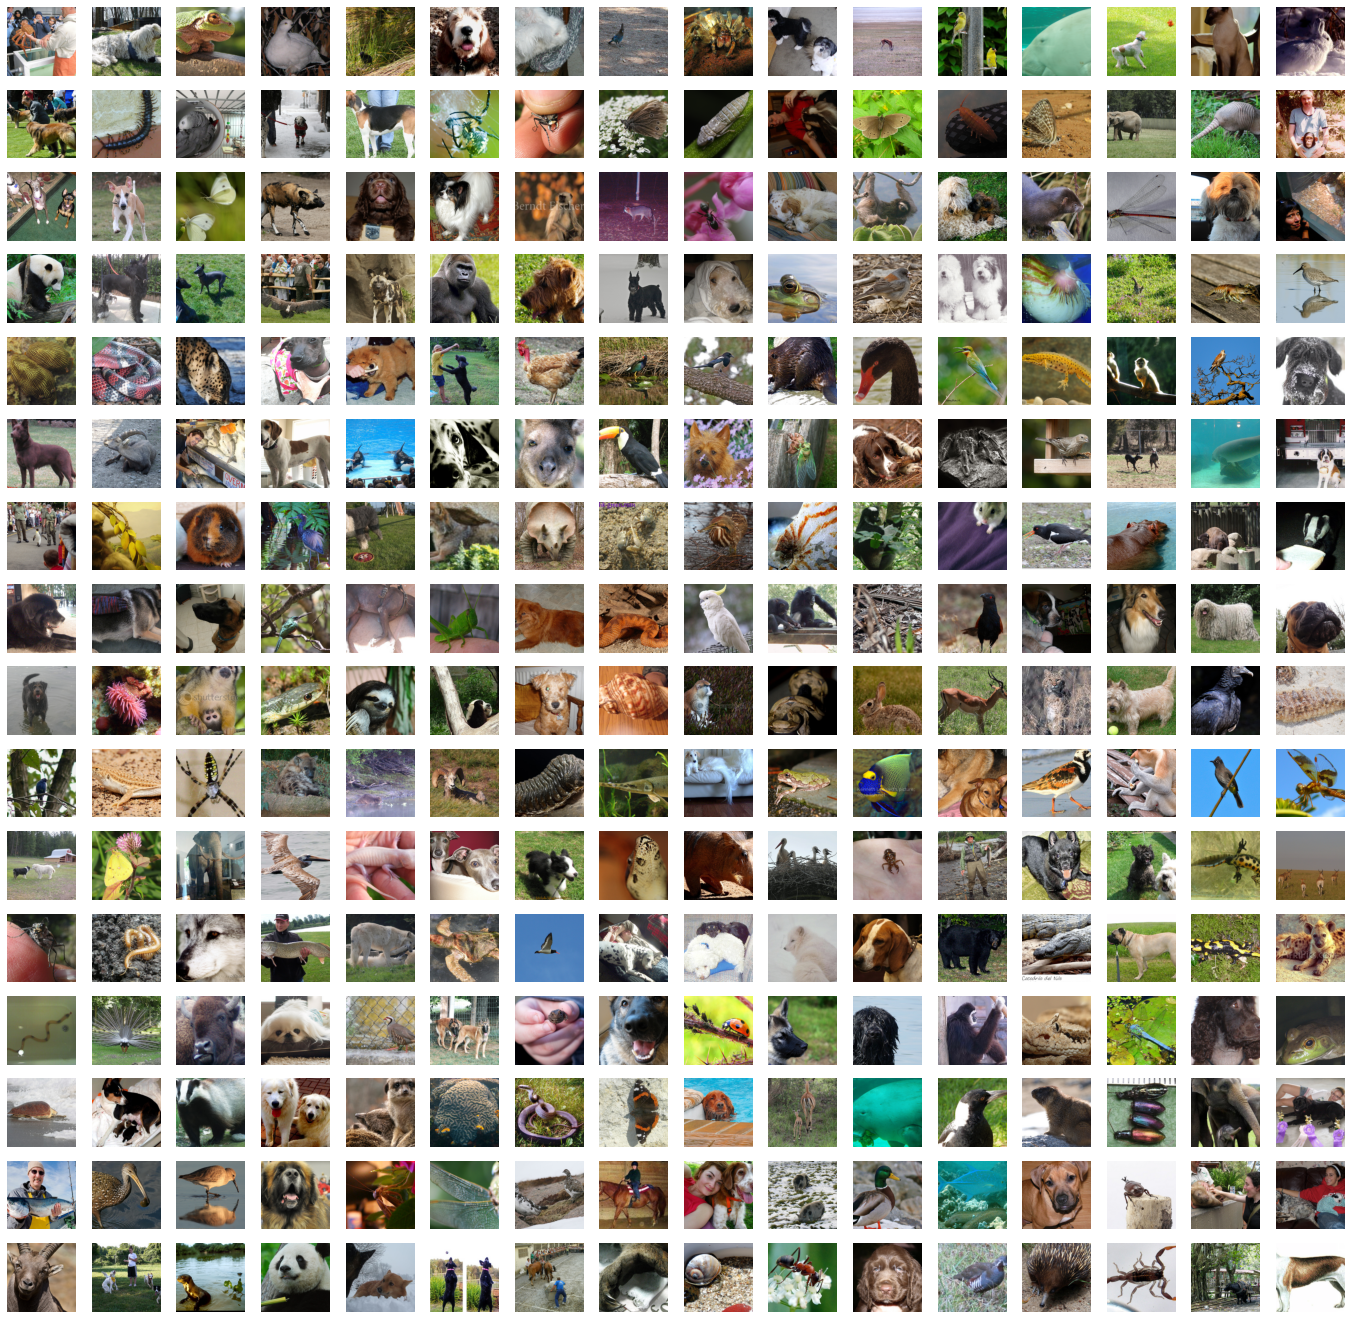

In [6]:
user.plot(true_user_data)

### Now reconstruct  the single "fished" user data point:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution. This reconstruction does not always work, but is at least as powerful as the basic attack (here an optimization-based Inverting Gradients variant) applied to a single data point.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.3588 |  Task loss: 919.2381 | T: 0.43s
| It: 1001 | Rec. loss: 0.1706 |  Task loss: 717.6017 | T: 48.65s
| It: 2001 | Rec. loss: 0.1853 |  Task loss: 703.0999 | T: 40.79s
| It: 3001 | Rec. loss: 0.1674 |  Task loss: 708.8867 | T: 41.62s
| It: 4001 | Rec. loss: 0.1532 |  Task loss: 712.9750 | T: 41.95s
| It: 5001 | Rec. loss: 0.1591 |  Task loss: 706.5532 | T: 41.57s
| It: 6001 | Rec. loss: 0.1538 |  Task loss: 717.2209 | T: 40.27s
| It: 7001 | Rec. loss: 0.1490 |  Task loss: 714.4706 | T: 40.81s
| It: 8001 | Rec. loss: 0.1258 |  Task loss: 702.7438 | T: 41.51s
| It: 9001 | Rec. loss: 0.1246 |  Task loss: 708.6604 | T: 40.99s
| It: 10001 | Rec. loss: 0.1307 |  Task loss: 715.9234 | T: 42.40s
| It: 11001 | Rec. loss: 0.1300 |  Task loss: 712.3401 | T: 42.07s
| It: 12001 | Rec. loss: 0.1213 |  Task loss: 709.3016 | T: 42.39s
| It: 13001 | Rec. loss: 0.1397 |  Task loss: 709.2811 | T: 41.75s
| It: 14001 | Rec. loss: 0.1259 |  Task loss: 705.3959 | T: 41.39s
| It: 150

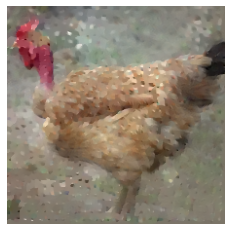

In [8]:
fished_data = dict(data=reconstructed_user_data["data"][server.secrets["ClassAttack"]["target_indx"]], 
                   labels=None)
user.plot(fished_data)

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

First, identify which GT image this is (This saves us from computing metrics for the entire batch):

In [9]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0645 | PSNR: 12.34 | FMSE: 1.5502e+02 | LPIPS: 0.92|
 R-PSNR: 12.91 | IIP-pixel: 1.56% | SSIM: 0.0077 | max R-PSNR: 20.23 | max SSIM: 0.4666 | Label Acc: 100.00%


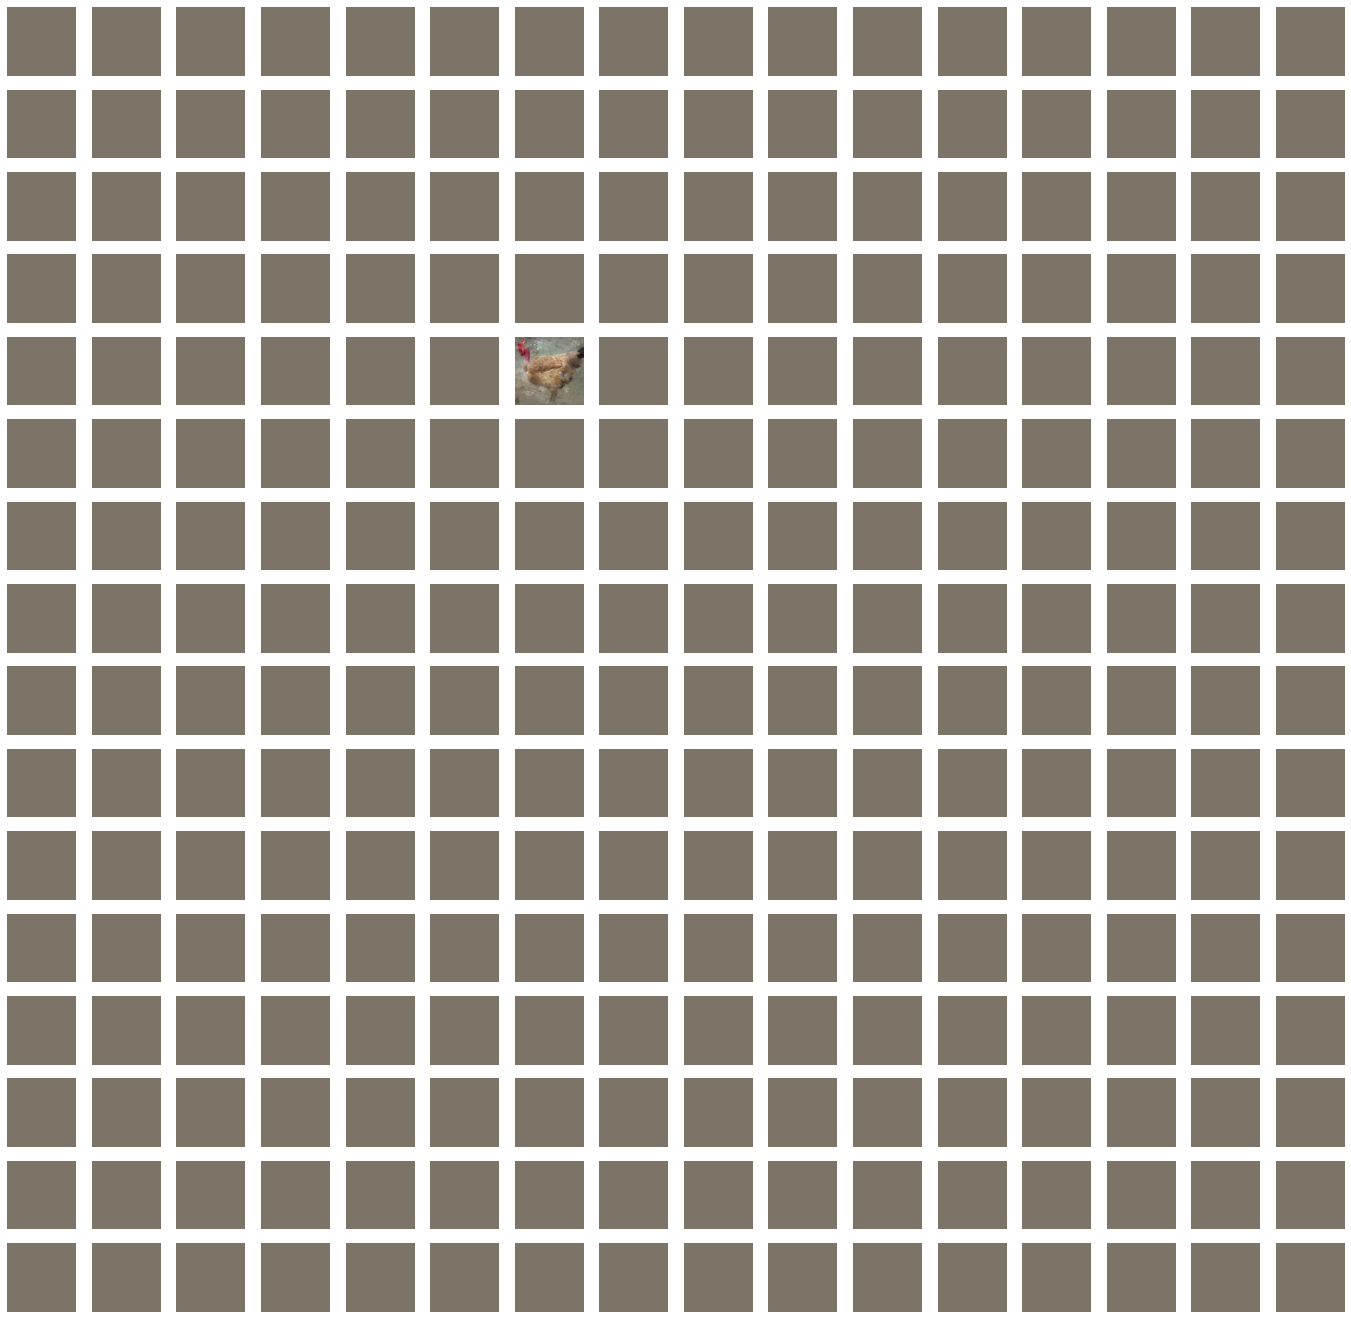

In [10]:
user.plot(reconstructed_user_data)

#### Which gradient is non-trivial

In [11]:
# from breaching.cases.malicious_modifications.classattack_utils import print_gradients_norm, cal_single_gradients
# single_gradients, single_losses = cal_single_gradients(user.model, loss_fn, true_user_data, setup=setup)
# print_gradients_norm(single_gradients, single_losses)

### Notes:
* You can use `cal_single_gradients` and `print_gradients_norm` from `malicious_modifications.classattack_utils` to verify that only one of the user data points has a non-neglible gradient norm
* Could probably optimize hyperparameters longer to find a more convincing example. The base attack is letting us down a bit with this goldfish example.